In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset,Subset,DataLoader,ConcatDataset
from sklearn.model_selection import train_test_split
import os,sys,time
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm

## check available device
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print("device:", device)

device: cpu


In [2]:
random_seed = 42

# Python RNG
np.random.seed(random_seed)

# Torch RNG
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
max_epochs = 40
batch_size = 50
lr = 0.01
train_size = 0.8

n_samples = 1000
n_features = 5

In [4]:
## features
def create_regression_data(n_samples, n_features):
    x = np.random.normal(0,1,size=(n_samples, n_features))

    ## target:
    y = x[:,0] + x[:,1] + 2*x[:,2] + 3*x[:,3] + 4*x[:,4] + x[:,0]*x[:,2] + 0.5*x[:,3]*x[:,4] + np.random.rand()
    
    return x,y

In [5]:
features, target = create_regression_data(n_samples, n_features)
features.shape, target.shape

((1000, 5), (1000,))

In [6]:
#### Build dataset
class BuildDataset(Dataset):
    def __init__(self, features, targets):
        
        self.features = features
        self.targets = targets            ## gene_expression_values
        self.dim = self.features.shape[2] ## 2048

    def __getitem__(self, index):
        sample = torch.Tensor(self.features[index,:,:]).float().t()
        target = self.targets[index]
        return sample, target

    def __len__(self):
        return self.features.shape[0]

In [7]:
n_train = int(train_size*n_samples)
print(n_train)

i_train = np.random.choice(n_samples, n_train, replace=False)
i_test = np.setdiff1d(np.arange(n_samples), i_train)

dataset = BuildDataset(features[:,:,np.newaxis], target[:, np.newaxis])
train_set = Subset(dataset, i_train)
test_set = Subset(dataset, i_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

800


In [8]:
class MLP_regression(nn.Module):
    def __init__(self, n_inputs=5, n_outputs=1, n_hiddens=4, dropout=0.1):
        super(MLP_regression, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(n_inputs, n_hiddens),
            #nn.ReLU(),
            nn.Dropout(dropout)
            )
        
        self.fc2 = nn.Sequential(
            nn.Linear(n_hiddens, n_outputs),
            #nn.ReLU(),
            nn.Dropout(dropout)
            )
        
        ## initialization
        #self.fc2.bias = None ###!!!!
        
    ###------------
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.mean(x, axis=2)
        
        return x

In [9]:
n_inputs = 5
n_ouputs = 1
n_hiddens = 4
dropout = 0.05

In [10]:
model = MLP_regression(n_inputs, n_ouputs, n_hiddens, dropout)
model.to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

MLP_regression(
  (fc1): Sequential(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1): Dropout(p=0.05, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
    (1): Dropout(p=0.05, inplace=False)
  )
)


In [11]:
def count_parameters(model):
    ## count the number of parameters in a model
    return sum([p.numel() for p in model.parameters()])

In [12]:
n_parameters = count_parameters(model)
print("n_parameters:", n_parameters)

n_parameters: 29


In [13]:
def train_model(model, optimizer, train_loader, max_epochs):
    model.train()
    loss_fn = nn.MSELoss()    
    train_loss_list = []

    for e in range(max_epochs):
        labels = []
        preds = []
        loss_list = []

        for x,y in train_loader:       ## repeat times = len(train_set)/batch_size
            
            labels += [y]

            pred = model(x.float().to(device))       
            #print("pred.shape:", pred.shape)

            loss = loss_fn(pred, y.float().to(device))
            loss_list += [loss.detach().cpu().numpy()] ## add loss of each sample to a list

            ## reset gradients to zero
            optimizer.zero_grad()

            ## compute gradients
            loss.backward()

            ## update parameters using gradients
            optimizer.step()

            #pred = nn.ReLU()(pred)                      ## y_pred
            preds += [pred.detach().cpu().numpy()]      ## convert to numpy

        #print(e,np.mean(loss_list))

        train_loss = np.mean(loss_list)  
        train_loss_list.append(train_loss)
        
    return train_loss_list

In [14]:
def predict(model, dataloader):    
    model.eval()
    loss_fn = nn.MSELoss()
    
    labels = []
    preds = []
    loss_list = []

    with torch.no_grad():
        for x, y in dataloader:         ## load x, y from dataloader for each batch
            labels += [y]                        ## y_actual
            pred = model(x.float().to(device))   ## y_pred = model(x)

            loss = loss_fn(pred, y.float().to(device))
            loss_list += [loss.detach().cpu().numpy()] ## convert to numpy

            #pred = nn.ReLU()(pred)                    ## y_pred
            preds += [pred.detach().cpu().numpy()]     ## convert to numpy
    
    ## convert list to 2D array
    labels = np.concatenate(labels)
    preds = np.concatenate(preds)
    
    return labels, preds

In [15]:
train_loss = train_model(model, optimizer, train_loader, max_epochs)

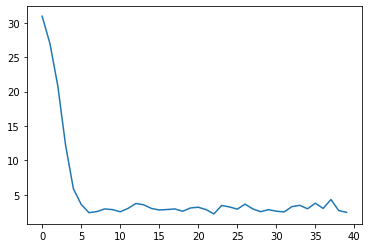

In [16]:
plt.plot(train_loss)

In [17]:
labels, preds = predict(model, test_loader)

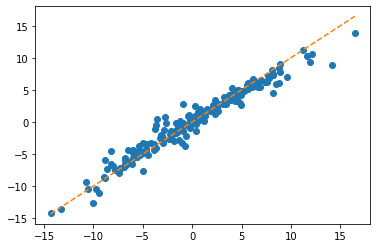

In [18]:
plt.plot(labels, preds, "o")
plt.plot([labels.min(), labels.max()],[labels.min(), labels.max()],"--")